In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os, subprocess
import pandas as pd

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, pin_memory=True)

testset = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16, pin_memory=True)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


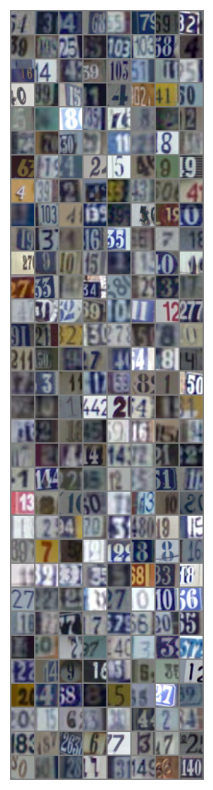

 4  3  4  6  5  7  9  2  9  0  5  5  0  0  8  4  1  4  4  9  0  1  1  5  0  9  1  1  4  2  1  0  5  4  8  5  7  8  2  2  2  7  0  3  1  2  8  5  6  1  4  2  5  4  9  9  4  9  2  4  3  3  0  4  1  0  4  3  9  5  1  0  1  3  1  6  5  6  7  1  2  9  0  5  1  1  0  1  7  3  4  4  8  2  3  7  4  1  2  9  0  1  1  7  1  1  2  3  7  5  8  0  1  0  9  7  4  4  8  4  7  3  1  1  5  8  1  5  2  0  1  4  2  4  1  1  1  2  1  5  9  6  5  3  7  2  4  4  4  2  1  2  1  4  2  5  2  5  1  1  1  8  1  0  1  1  1  2  1  2  4  0  3  8  9  1  9  7  5  2  2  8  8  1  1  2  3  3  5  8  3  8  2  2  2  3  7  0  0  6  1  2  7  7  7  6  0  5  4  0  2  7  4  3  3  7  2  1  9  1  3  5  3  1  2  4  8  8  5  5  7  9  0  1  6  3  8  4  2  4  8  8  6  6  7  3  7  2  0  0  2  1  3  4  6  4


In [3]:
def imshow(img):
    img = img * 0.5 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and first digit label
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:>2s}' for j in range(batch_size)))


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [4]:
class LargerNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Deeper Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, 5) # Increased out_channels from 6 to 16
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5) # Increased out_channels from 16 to 32
        self.conv3 = nn.Conv2d(32, 64, 3) # Added a new convolutional layer

        # Adjusted input features for fc1 based on new conv layers and pooling
        # After conv1 (32x32 -> 28x28 -> 14x14)
        # After conv2 (14x14 -> 10x10 -> 5x5)
        # After conv3 (5x5 -> 3x3) -- No pooling after conv3 in this example
        # The output size of conv3 is (3x3) and it has 64 channels
        # This calculation might need adjustment depending on stride and padding. For this example, let's assume it leads to 64 * 3 * 3

        # To dynamically calculate the input features to the first FC layer:
        # Let's run a dummy tensor through the conv layers to get the shape
        dummy_input = torch.randn(1, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x)) # No pooling after conv3 for larger feature maps
        self.flattened_features = x.numel() // x.shape[0] # Get features per sample

        # Wider Fully Connected Layers
        n_fc12 = 256 # Increased from 100
        n_fc23 = 128 # Increased from 100
        n_fc34 = 64  # Increased from 100

        self.fc1 = nn.Linear(self.flattened_features, n_fc12)
        self.fc2 = nn.Linear(n_fc12, n_fc23)
        self.fc3 = nn.Linear(n_fc23, n_fc34)
        self.fc4 = nn.Linear(n_fc34, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x)) # Apply conv3 and activation
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# Instantiate the new, larger network
larger_net = LargerNet()
print("LargerNet class defined successfully.")
print(larger_net)

LargerNet class defined successfully.
LargerNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.001*(batch_size/4)
optimizer = optim.SGD(larger_net.parameters(), lr=lr, momentum=0.9)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
larger_net.to(device)

cuda:0


LargerNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = larger_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
PATH = './models/svhn_larger_net2.pth'
torch.save(larger_net.state_dict(), PATH)

[1,   200] loss: 0.224
[2,   200] loss: 0.224
[3,   200] loss: 0.224
[4,   200] loss: 0.224
[5,   200] loss: 0.223
[6,   200] loss: 0.129
[7,   200] loss: 0.048
[8,   200] loss: 0.037
[9,   200] loss: 0.030
[10,   200] loss: 0.026
Finished Training


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = larger_net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = larger_net(inputs) # Changed 'images' to 'inputs' to use the data already on the device
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 90.2 %
Accuracy for class: 1     is 94.7 %
Accuracy for class: 2     is 94.5 %
Accuracy for class: 3     is 78.7 %
Accuracy for class: 4     is 93.9 %
Accuracy for class: 5     is 90.8 %
Accuracy for class: 6     is 83.0 %
Accuracy for class: 7     is 90.6 %
Accuracy for class: 8     is 84.9 %
Accuracy for class: 9     is 91.3 %
